In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import brentq
from tsfit import TSFit
from beta import sse, beta
import rw
import concurrent.futures
from scipy import integrate
import matplotlib.pyplot as plt
%matplotlib inline

This notebook deals with expected errors of tsfit. It was mostly used for illustrations in the tsfit paper. It is included here for reference purposes.<br>

**Warning**: Parallel Processing (futures.ProcessPoolExecutor) may not run on some versions of macOS (tested on Linux/Ubuntu).

In [2]:
def plot_sse(mL, file=None):
    '''Plots the expected theoretical adjusted SSE for point estimates as a function
        of r, where r is the ratio of the time of the point estimate relative
        to the time horizon h.
        This plot is ideal for thinking about how the error changes with
        respect to the estimation time where h is fixed (and the indeterminate
        is p).
    '''
    xrange = np.linspace(0.15, 10, 200)
    plt.figure(figsize=(12,8))
    #plt.figure(figsize=(4,3))
    for m in mL:
        y = sse(m)(xrange)
        plt.plot(xrange, y, label='m='+str(m))
    plt.xlabel('r')
    plt.ylabel('SSE')
    plt.legend()
    if file is not None:
        plt.savefig(file, bbox_inches='tight')

In [3]:
def plot_sse_h(mL, file=None):
    '''Plots SSE as a function of h if h is expressed as a fraction of the period.
        Note that only the interval (0,1] is of interest for practical applications.
    '''
    xrange = np.linspace(0.001, 1, 200)
    plt.figure(figsize=(12,18))
    for m in mL:
        y = sse(m)(1/xrange)
        plt.plot(xrange, y, label='m='+str(m))
    if len(mL) <= 4:
        plt.legend()
    plt.ylim([0,0.22])
    if file is not None:
        plt.savefig(file, bbox_inches='tight')

In [4]:
def onerun_pp(m, steps, pp, t, h):
    rwalk = rw.norm_rw(3 * steps)
    tsfit = TSFit(m, h=h*steps, period=steps)
    tsfit.fit(rwalk)
    tsfit.transform()
    return t, tsfit.point_error() ** pp
    
def optimal_h_pp(m=1, pp=2, steps=1000, trials=400, file=None):
    df = pd.DataFrame()
    hrange = np.linspace(1/(2*m), 1.2/m, 300)
    #hrange = np.linspace(0.01, 1, 300)
    for h in hrange:
        with concurrent.futures.ProcessPoolExecutor(max_workers=None) as executor:
            futures = [executor.submit(onerun_pp, m, steps, pp, t, h) for t in range(trials)]
            completed = concurrent.futures.as_completed(futures)
            for future in completed:
                t, score = future.result()
                df.at[t, h] = score

    score = df.mean() / steps ** (pp/2)
    scoreMA = score.rolling(11, center=True).mean().dropna()
    #plt.figure(figsize=(12,8))
    plt.figure(figsize=(4,3))
    plt.plot(score, '+k', markersize=1, label='score')
    plt.plot(scoreMA, 'ob', markersize=2, label='MA11')
    
    #theoretical sse curve
    if pp == 1 or pp == 2:
        if pp == 2:
            y = sse(m)(1/hrange)
        else:
            y = np.sqrt(sse(m)(1/hrange) * 2 / np.pi)
        plt.plot(hrange, y, 'r', label='expected')
    #plt.xlabel('h')
    #plt.ylabel('SSE')
    plt.legend()
    plt.title('m=' + str(m) + '  pp=' + str(pp))
    if file is not None:
        #plt.savefig(file, bbox_inches='tight')
        plt.savefig(file)

In [5]:
def onerun_lp(m, steps, lp, t, h):
    rwalk = rw.norm_rw(3 * steps)
    tsfit = TSFit(m, h=h*steps, period=steps)
    tsfit.fit(rwalk)
    tsfit.transform()
    score = tsfit.lp_error(lp)
    return t, score, score ** lp
    
def optimal_h_lp(m=1, lp=2, steps=1000, trials=400, file=None):
    df = pd.DataFrame()
    df2 = pd.DataFrame()
    hrange = np.linspace(1/(3*m), 1/(1.5 * m), 300)
    #hrange = np.linspace(0.01, 1, 300)
    for h in hrange:
        with concurrent.futures.ProcessPoolExecutor(max_workers=None) as executor:
            futures = [executor.submit(onerun_lp, m, steps, lp, t, h) for t in range(trials)]
            completed = concurrent.futures.as_completed(futures)
            for future in completed:
                t, score, score2 = future.result()
                df.at[t, h] = score
                df2.at[t,h] = score2
    score = df.mean() / np.sqrt(steps)
    score2 = df2.mean() / (steps ** (lp/2))
    
    #plt.figure(figsize=(12,8))
    plt.figure(figsize=(4,3))
    scoreMA = score.rolling(11, center=True).mean().dropna()
    score2MA = score2.rolling(11, center=True).mean().dropna()
    plt.plot(score, '+k', markersize=1, label='score')
    if lp == 2:
        plt.plot(scoreMA, 'o', markerfacecolor='none', markeredgecolor='g', markersize=2, label='MA11')
    plt.plot(score2MA ** (1/lp), 'ob', markersize=2, label='2MA11')
    
    #theoretical sse curve
    if lp == 1 or lp == 2:
        def error(p, h):
            return (p * sse(m)(p/h)) ** (lp/2)
        y = np.zeros(hrange.size)
        y2 = np.zeros(hrange.size)
        for i in range(hrange.size):
            fx = lambda x: error(x, hrange[i])
            z = integrate.quad(fx, 0, 1)[0]
            z = z ** (1/lp)
            if lp == 2:
                y[i] = z
            else:
                y[i] = z * np.sqrt(2 / np.pi)
        plt.plot(hrange, y, 'r', label='expected2')
    plt.legend()
    plt.title('m=' + str(m) + '  lp=' + str(lp))
    if file is not None:
        #plt.savefig(file, bbox_inches='tight')
        plt.savefig(file)

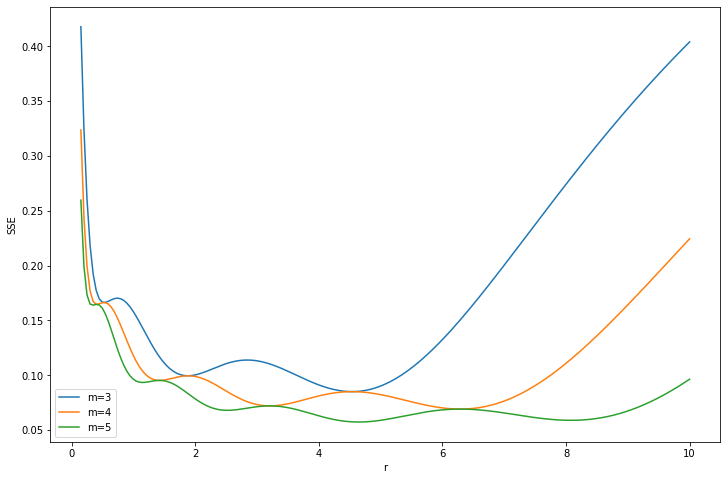

In [6]:
plot_sse([3, 4, 5], file='sse')

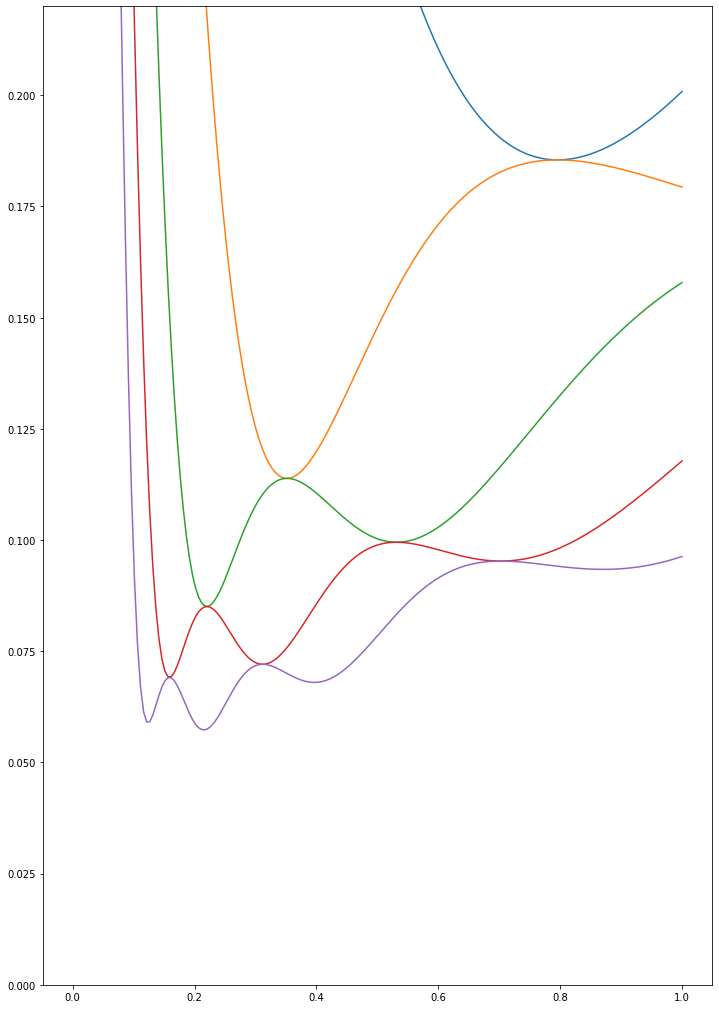

In [7]:
plot_sse_h([1, 2, 3, 4, 5])

CPU times: user 58.8 s, sys: 17.3 s, total: 1min 16s
Wall time: 4min 36s


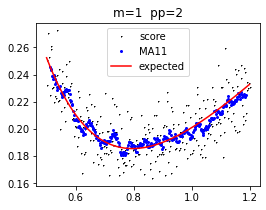

In [8]:
%time optimal_h_pp(m=1, pp=2, file='pp_1_2')

CPU times: user 1min 2s, sys: 18 s, total: 1min 20s
Wall time: 6min 24s


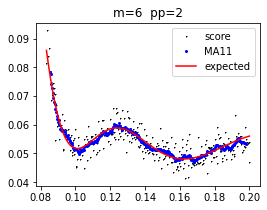

In [9]:
%time optimal_h_pp(m=6, pp=2, file='pp_6_2')

CPU times: user 1min 8s, sys: 18.2 s, total: 1min 26s
Wall time: 5min 50s


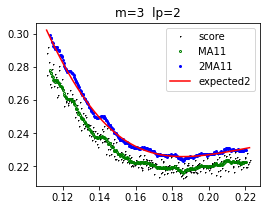

In [10]:
%time optimal_h_lp(m=3, lp=2, file='lp_3_2')

CPU times: user 1min 12s, sys: 18.5 s, total: 1min 31s
Wall time: 5min 59s


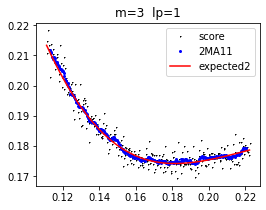

In [11]:
%time optimal_h_lp(m=3, lp=1, file='lp_3_1')

The following is code for a Figure in section 5 of the paper. This will likely not serve as a template for code.

In [12]:
def betaf(m, k):
    def func(r):
        val = 0
        for i in range(0, m):
            val += beta(m, k, i) * r ** i
        return -beta(m, k, 0) + val * np.exp(-r)
    return func

def plot_onebeta(m):
    xrange = np.linspace(0.05, 6.5, 500)
    plt.figure(figsize=(12,8))
    #plt.figure(figsize=(4,3))
    
    for var in [m, m+1]:
        y = sse(var)(xrange)
        plt.plot(xrange, y, label=r'$SSE^{{({})}}$'.format(var))
    beta0 = betaf(m, 0)
    plt.plot(xrange, (1 - beta0(xrange)) ** 2, 'k', label=r'$(1-\beta_0^{{({})}})^2$'.format(m))
    
    close = xrange[abs(sse(m)(xrange) - (1 - beta0(xrange)) ** 2) < 0.004]
    diff = np.empty(close.size)
    diff[0] = np.inf
    diff[1:] = np.diff(close)
    mask = diff > 0.1
    diff = close[mask]
    print(diff)
    print(close)
    diffy = sse(m)(diff)
    
    plt.plot(diff, diffy, 'o', markersize=10, markerfacecolor='none', markeredgecolor='k')
    plt.xlabel('r')
    plt.ylim(0, 0.25)
    plt.legend()
    
    plt.savefig('beta0', bbox_inches='tight')

[0.52825651 0.73507014 1.87254509 2.82905812 4.52234469]
[0.52825651 0.73507014 0.74799599 1.87254509 1.88547094 1.89839679
 2.82905812 2.84198397 2.85490982 4.52234469 4.53527054 4.54819639]


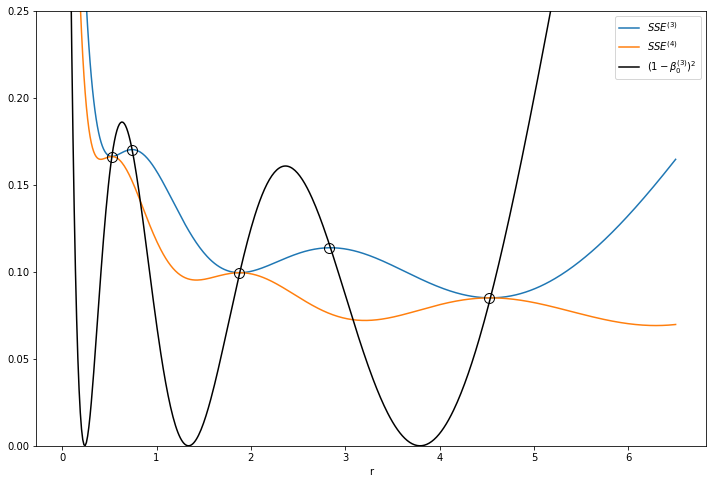

In [13]:
plot_onebeta(3)

In [14]:
def rootfunc(m):
    def func(r):
        return 1 / (np.pi * np.sqrt(2 * m * r - r ** 2))
    return func

def plot_envelope(m):
    xrange = np.linspace(0.3, 2 * (m) - 0.5, 2000)
    #xrange = np.linspace(0.4, 20, 300)
    plt.figure(figsize=(12,8))
    #plt.figure(figsize=(4,3))
    plt.plot(xrange, sse(m)(xrange), 'k', label=r'$SSE^{{({})}}$'.format(m))
    #plt.plot(xrange, rootfunc(m-1)(xrange), 'b')
    twom = 2 * m
    plt.plot(xrange, rootfunc(m)(xrange), 'b', label=r'$1/(\pi\sqrt{{{}r-r^2}}))$'.format(twom))
    #plt.plot(xrange, rootfunc(m+1)(xrange), 'b')
    #plt.plot(xrange, func(xrange), 'k')
    plt.xlabel('r')
    plt.ylim(0, 0.1)
    plt.legend()
    
    plt.savefig('squareconj', bbox_inches='tight')

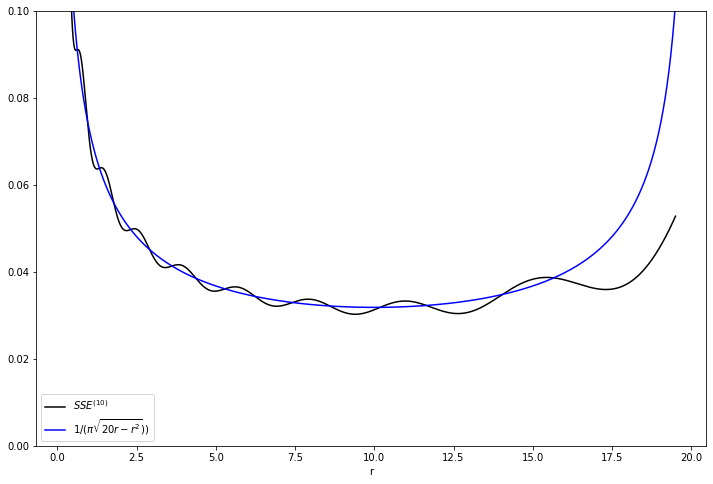

In [15]:
plot_envelope(10)